Import packages

In [87]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

Data import from excel

In [88]:
df = pd.read_excel("stock_data.xlsx", sheet_name="data")

In [90]:
df.head()

,RIC,24.10.2023,23.10.2023,22.10.2023,21.10.2023,20.10.2023,19.10.2023,18.10.2023,17.10.2023,16.10.2023,...,10.01.2013,09.01.2013,08.01.2013,07.01.2013,06.01.2013,05.01.2013,04.01.2013,03.01.2013,02.01.2013,01.01.2013
0,.DJI,29618.45,29435.27,29605.85,29605.85,29605.85,29862.24,30086.48,30383.70,30371.98,...,12039.23,11967.10,11911.99,11961.54,12007.05,12007.05,12007.05,11967.86,11986.80,NaN
1,.STOXX,388.84,387.13,387.62,387.62,387.62,392.99,397.71,401.95,402.34,...,256.89,257.58,255.82,256.16,257.23,257.23,257.23,256.34,255.00,NaN
2,.FTSE,6604.17,6590.89,6615.29,6615.29,6615.29,6702.33,6781.40,6859.34,6819.49,...,5452.92,5450.36,5410.13,5419.92,5442.49,5442.49,5442.49,5404.51,5386.66,NaN
3,.GDAXI,13298.20,13227.40,13225.39,13225.39,13225.39,13445.92,13490.32,13630.44,13618.19,...,6889.06,6899.78,6877.76,6910.68,6949.74,6949.74,6949.74,6931.93,6951.90,NaN
4,.HSI,15185.33,15346.73,15346.73,15346.73,15346.73,15457.34,15847.55,15884.03,15765.19,...,20871.75,20750.35,20654.47,20849.80,20851.00,20851.00,20851.00,20911.33,20833.92,NaN


In [91]:
df.shape

(5, 3950)

Data modelling

In [92]:
# Unpivot columns except 'RIC' column
df = pd.melt(df, id_vars='RIC', var_name='Trade Date', value_name='Universal Close Price')

# Convert 'Trade Date' to date format
df['Trade Date'] = pd.to_datetime(df['Trade Date'], format='%d.%m.%Y')

# Create pivot table
df = df.pivot(index='Trade Date', columns='RIC', values='Universal Close Price')

In [93]:
# Delete rows in case it is weekend
df = df[df.index.weekday < 5]

Get Nikkei 225 and S&P 500 data from yahoo finance

In [94]:
# Set start and and date
start_date = df.index.min()
end_date = df.index.max()

In [95]:
# Download yahoo finance data
tickers_list = ['^N225', '^GSPC']
yahoo_object = yf.Tickers(tickers_list)
yahoo_prices = yahoo_object.history(start=start_date, end=end_date, interval='1d').Close

[*********************100%***********************]  2 of 2 completed


In [96]:
# Round stock prices
yahoo_prices = yahoo_prices.round(decimals = 2)

# Rename columns
map_tickers = {'^GSPC': '.INX',
               '^N225': '.N225'}
yahoo_prices = yahoo_prices.rename(columns=map_tickers)

In [97]:
yahoo_prices.head(5)

,.INX,.N225
Date,,
2013-01-02,1462.42,NaN
2013-01-03,1459.37,NaN
2013-01-04,1466.47,10688.11
2013-01-07,1461.89,10599.01
2013-01-08,1457.15,10508.06


Merge dataframes

In [98]:
# Join yahoo finance data to original dataframe
df = df.join(yahoo_prices)

In [99]:
df.head(5)

,.DJI,.FTSE,.GDAXI,.HSI,.STOXX,.INX,.N225
Trade Date,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,11986.80,5386.66,6951.90,20833.92,255.00,1462.42,NaN
2013-01-03,11967.86,5404.51,6931.93,20911.33,256.34,1459.37,NaN
2013-01-04,12007.05,5442.49,6949.74,20851.00,257.23,1466.47,10688.11
2013-01-07,11961.54,5419.92,6910.68,20849.80,256.16,1461.89,10599.01


Analyse missing values

In [100]:
# Count missing values in a dataframe
df.isna().sum(axis=0)

.DJI        1
.FTSE       1
.GDAXI      1
.HSI        1
.STOXX      1
.INX      100
.N225     179
dtype: int64

<Axes: xlabel='Trade Date'>

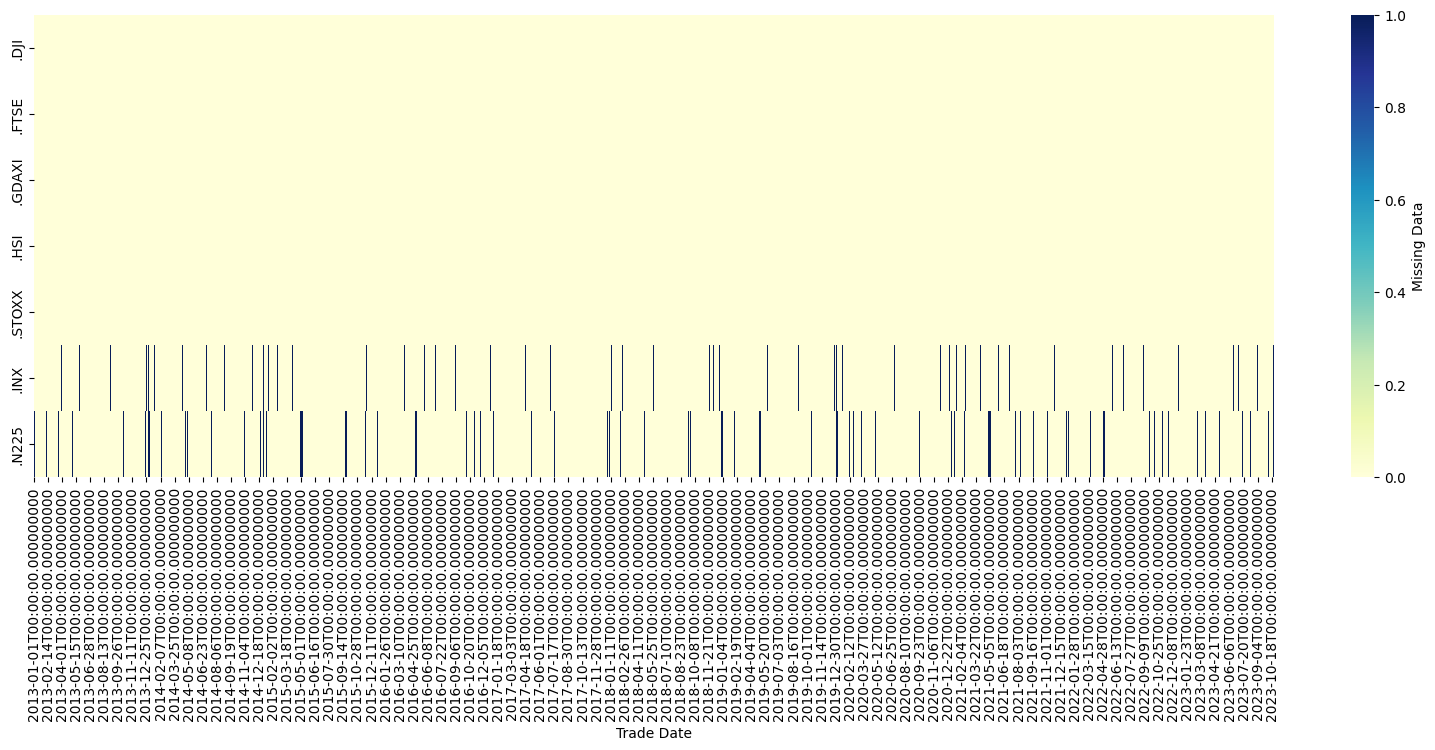

In [101]:
# Visualize missing values
plt.figure(figsize=(20,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [102]:
# Fill missing values with previous available data. When starting values are missing, take next available
df = df.ffill().bfill()

In [103]:
# Any rows with missing data?
df[df.isna().any(axis=1)]

,.DJI,.FTSE,.GDAXI,.HSI,.STOXX,.INX,.N225
Trade Date,,,,,,,


Data modelling 2

In [104]:
# Reorder columns
df = df[['.DJI', '.STOXX', '.FTSE', '.GDAXI', '.N225', '.HSI','.INX']]

# Index values into columns
df = df.reset_index()

# Unpivot columns
df = pd.melt(df, id_vars='Trade Date', var_name='RIC', value_name='Universal Close Price')

In [105]:
# Functions

def dot_separated_date(date):
    """
    Formats a given date object into a dot-separated string.

    Args:
        date (datetime.date): The date to be formatted.

    Returns:
        str: A string representing the date in the format 'dd.mm.yyyy'.
    """
    date_dot_sep = date.strftime('%d.%m.%Y')
    return date_dot_sep

def format_float_to_desired(value):
    """
    Formats a floating-point number as a string with comma and dot swapped.

    Args:
        value (float): The floating-point number to be formatted.

    Returns:
        str: A string representation of the number with ',' and '.' swapped, formatted as 'X,XXX.XX'.
    """
    formatted_value = '{:,.2f}'.format(value).replace(',', 'X').replace('.', ',').replace('X', '.')
    return formatted_value

In [106]:
df['Trade Date'] = df['Trade Date'].apply(dot_separated_date)
df['Universal Close Price'] = df['Universal Close Price'].apply(format_float_to_desired)

In [107]:
df.head(5)

,Trade Date,RIC,Universal Close Price
0,01.01.2013,.DJI,"11.986,80"
1,02.01.2013,.DJI,"11.986,80"
2,03.01.2013,.DJI,"11.967,86"
3,04.01.2013,.DJI,"12.007,05"
4,07.01.2013,.DJI,"11.961,54"


Create file per date

In [108]:
date_sequence = df['Trade Date'].unique()

In [109]:
def get_filename(date):
    """
    Generates a filename based on a dot-separated date.

    Args:
        date (str): A string representing a date in the format 'dd.mm.yyyy'.

    Returns:
        str: A formatted filename in the format 'yyyymmdd_stock_index'.

    Example:
        If date is '25.10.2023', the function will return '20231025_stock_index'.
    """
    date_list = date.split('.')[::-1]
    prefix_date = ''.join(date_list)
    filename = f"{prefix_date}_stock_index"
    return filename


In [110]:
# for loop to create an stock index prices file for each date
for date_item in date_sequence:
    # Get date
    df_subset = df[df['Trade Date'] == date_item]
    # Get file name & set path
    file_name = get_filename(date_item)
    file_name_path = f"files_created/{file_name}.csv"
    # Create a file
    df_subset.to_csv(file_name_path, index=None, sep=',')

Test: Merge all files

In [111]:
# merging the files 
file_format = os.path.join('files_created', '*stock*') 
  
# A list of all joined files is returned 
files_list = glob.glob(file_format) 

In [112]:
df_concat = pd.concat([pd.read_csv(file, decimal=',') for file in files_list], ignore_index=True)

In [113]:
df_concat.head(7)

,Trade Date,RIC,Universal Close Price
0,01.01.2013,.DJI,"11.986,80"
1,01.01.2013,.STOXX,"255,00"
2,01.01.2013,.FTSE,"5.386,66"
3,01.01.2013,.GDAXI,"6.951,90"
4,01.01.2013,.N225,"10.688,11"
5,01.01.2013,.HSI,"20.833,92"
6,01.01.2013,.INX,"1.462,42"
